# Example 2

This notebook computes the total cross sections for processes of interest.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import DarkNews as dn
from DarkNews import *

In [3]:
# targets
proton = detector.NuclearTarget("H1")
C12 = detector.NuclearTarget("C12")
Ar40 = detector.NuclearTarget("Ar40")

In [12]:
def compute_xsecs(m4, mzprime):
    #########################
    # Set BSM parameters
    BSMparams = dn.model.Model()
    BSMparams.gD = np.sqrt(4*np.pi*0.1)
    BSMparams.epsilon = 1e-2
    BSMparams.Umu4  = 1e-10
    BSMparams.UD4 = 0.1
    BSMparams.m4 = m4
    BSMparams.mzprime = mzprime
    BSMparams.HNLtype = "dirac"
    BSMparams.set_high_level_variables()

    # Default values
    scope = {
    'FLAVORS': [pdg.numu],
    'UPSCATTERED_NUS': [pdg.neutrino4],
    'OUTGOING_NUS': [pdg.numu],
    'SCATTERING_REGIMES': ['coherent','p-el'],
    'INCLUDE_HC': True,
    'INCLUDE_HF': True,
    'INCLUDE_COH': True,
    'INCLUDE_PELASTIC': True}

    args = {'nu_projectile' : pdg.numu, 
            'nu_upscattered' : pdg.neutrino4,
            'nu_outgoing' : pdg.numu, 
            'final_lepton' : pdg.electron,
            }

    TARGETS = [proton, C12, Ar40]
    REGIMES = ['coherent','p-el']
    HEL_CASES = ['conserving','flipping']

    myMCs = {}
    for target in TARGETS:
        for regime in REGIMES:
            for hel in HEL_CASES:
                key = f'{target.name}_{hel}_{regime}'
                myMCs[key] = MC.MC_events(  
                    BSMparams, 
                    scattering_regime = regime,
                    nuclear_target= target,
                    helicity = hel,
                    **args)

                myMCs[key].set_theory_params(BSMparams)

    mc_lowT=myMCs['Ar40_conserving_coherent']

    enu_axis = np.geomspace(mc_lowT.Ethreshold*0.99, 5, 10)
    np.append(mc_lowT.Ethreshold*1.01, enu_axis)
    sigmas = {}
    for key, mc in myMCs.items():
        sigmas[key] = []
        print(key)
        for enu in enu_axis:
            sigmas[key].append(mc.get_total_xsec(enu))
        sigmas[key] = np.array(sigmas[key])
        mc.sigmas = sigmas[key]
        mc.enu_axis = enu_axis
    return myMCs

In [13]:
mcs_H_150 = compute_xsecs(0.150, 1.25)
mcs_H_420 = compute_xsecs(0.420, 1.25)
mcs_L_150 = compute_xsecs(0.150, 0.03)
mcs_L_420 = compute_xsecs(0.420, 0.03)

AttributeError: 'Model' object has no attribute 'ERANGE'

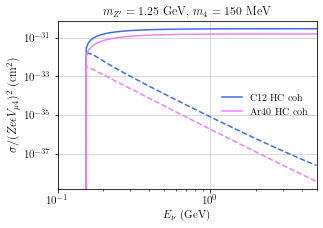

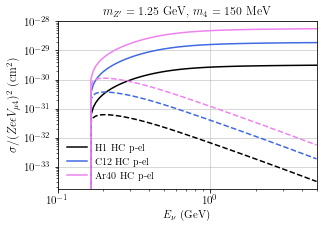

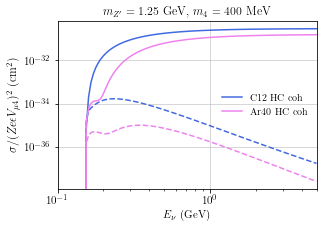

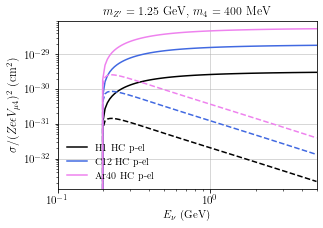

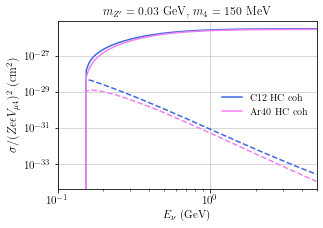

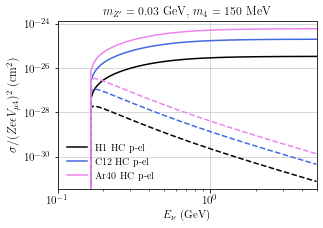

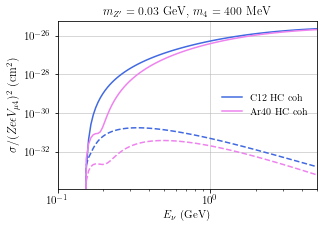

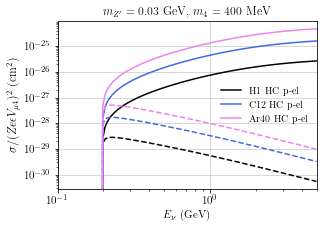

In [312]:
plot_xsecs(mcs_H_150,regime = 'coherent')
plot_xsecs(mcs_H_150,regime = 'p-el')

plot_xsecs(mcs_H_420,regime = 'coherent')
plot_xsecs(mcs_H_420,regime = 'p-el')

plot_xsecs(mcs_L_150,regime = 'coherent')
plot_xsecs(mcs_L_150,regime = 'p-el')

plot_xsecs(mcs_L_420,regime = 'coherent')
plot_xsecs(mcs_L_420,regime = 'p-el')

In [311]:
def plot_xsecs(theseMCs, regime = 'coherent'):
    fig, ax = pt.std_fig()
    enu_axis = np.geomspace(mc_lowT.Ethreshold*0.99, 5, 100)

    all_args={
            f'H1_conserving_{regime}': {'color': 'black', 'ls': '-'},
            f'C12_conserving_{regime}': {'color': 'royalblue', 'ls': '-'},
            f'Ar40_conserving_{regime}': {'color': 'violet', 'ls': '-'},
            f'H1_flipping_{regime}': {'color': 'black', 'ls': '--'},
            f'C12_flipping_{regime}': {'color': 'royalblue', 'ls': '--'},
            f'Ar40_flipping_{regime}': {'color': 'violet', 'ls': '--'},
            }    
    
    for key, mc in theseMCs.items():
        if regime in key:
            if regime == 'coherent' and "H1" in key:
                continue
            else:
                sigmas = mc.sigmas

                ls = '-' if ('conserving' in key) else '--'
                args = all_args[key]
                p = mc.ups_case.TheoryModel
                norm = (p.Umu4*p.epsilon*const.eQED*p.gD*p.UD4*mc.target.Z)**2
#                 print(norm/(mc.ups_case.Vij**2*mc.ups_case.Vhad**2))
                if 'conserving' in key:
                    ax.plot(enu_axis, sigmas/norm, label=key.replace("_", " ").replace("conserving", "HC").replace("coherent", "coh"), **args)
                else:
                    ax.plot(enu_axis, sigmas/norm, **args)

    ax.set_title(fr'$m_{{Z^\prime}}= {mc.ups_case.mzprime:.2f}$ GeV,  $m_4 = {mc.ups_case.m_ups*1e3:.0f}$ MeV')
    ax.set_yscale("log")
    ax.set_xscale("log")

    ax.set_xlabel(r"$E_\nu$ (GeV)")
    ax.set_ylabel(r"$\sigma/(Z e \epsilon V_{\mu 4})^2$ (cm$^2$)", fontsize=12)
    ax.set_xlim(0.1,np.max(enu_axis))
#     ax.set_ylim(1e-34,1e-26)

    ax.legend(loc="best", frameon=False)
    ax.grid(which='major', lw=0.5)

    fig.savefig(f"plots/xsecs/example_3+1_{mc.ups_case.mzprime:.2f}_{mc.ups_case.m_ups*1e3:.0f}_{regime}.pdf")

In [ ]:
#########################
# Set BSM parameters
BSMparams = dn.model.Model()

BSMparams.gD = np.sqrt(4*np.pi*0.1)
BSMparams.epsilon = 1e-3

BSMparams.Umu4  = 1e-4
BSMparams.UD4 = 0.1
BSMparams.m4 = 0.150
BSMparams.mzprime = 1.25
BSMparams.HNLtype = "dirac"



BSMparams.set_high_level_variables()
myMCs['C12_conserving_coherent'].set_theory_params(BSMparams)
myMCs['C12_conserving_coherent'].get_total_xsec(1)

In [6]:
mcp=myMCs['C12_conserving_p-el'].ups_case
mcc=myMCs['C12_conserving_coherent'].ups_case

In [297]:
myMCs['C12_conserving_p-el'].ups_case.TheoryModel.duV/(const.eQED*epsilon*2/3)#/(1/2 - 4/3*const.s2w)
myMCs['C12_conserving_p-el'].ups_case.TheoryModel.ddV/(-const.eQED*epsilon*1/3)#/(1/2 - 4/3*const.s2w)
myMCs['C12_conserving_p-el'].ups_case.TheoryModel.deV/(const.eQED*epsilon)#/(1/2 - 4/3*const.s2w)

1.0191464723688906

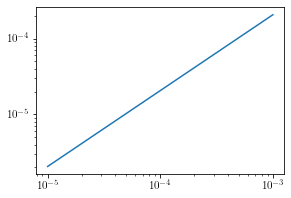

In [299]:
sigmas=[]
epsilons=np.geomspace(1e-5,0.001,40)
for epsilon in epsilons:
    BSMparams.epsilon = epsilon
    BSMparams.set_high_level_variables()
    myMCs['C12_conserving_p-el'].set_theory_params(BSMparams)
    sigmas.append(myMCs['C12_conserving_p-el'].ups_case.TheoryModel.duV)

plt.plot(epsilons,sigmas)
plt.yscale('log')
plt.xscale('log')


In [248]:
(-0.5 + 2*const.s2w)/(const.gweak/2/const.cw)

-0.1434469462678045

In [183]:
epsilons=np.geomspace(1e-5,0.1,40)
sigmas=[]
# for epsilon in epsilons:
#     BSMparams.epsilon = epsilon
#     BSMparams.set_high_level_variables()
#     myMCs['C12_conserving_p-el'].set_theory_params(BSMparams)
#     sigmas.append(myMCs['C12_conserving_p-el'].get_total_xsec(0.8))

   
umus=np.geomspace(1e-4,0.5,40)
sigmas=[]
for umu in umus:
    BSMparams.Umu4 = umu
    BSMparams.set_high_level_variables()
    myMCs['C12_conserving_p-el'].set_theory_params(BSMparams)
    sigmas.append(myMCs['C12_conserving_p-el'].get_total_xsec(0.8))


In [ ]:
fig, ax = pt.std_fig()

ax.plot(epsilons,sigmas)

ax.set_yscale('log')
ax.set_xscale('log')

ax.legend(loc="best", frameon=False)
ax.set_xlabel(r"Kinetic mixing $\epsilon$")
ax.set_ylabel(r"$\sigma$ cm$^2$)")
fig.savefig("plots/xsecs/C12_sigma_1GeV_vs_epsilon.pdf")

No handles with labels found to put in legend.


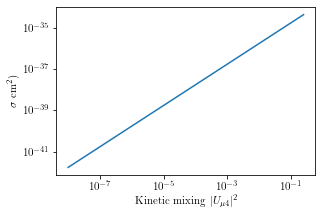

In [185]:
fig, ax = pt.std_fig()

ax.plot(umus**2,sigmas)

ax.set_yscale('log')
ax.set_xscale('log')

ax.legend(loc="best", frameon=False)
ax.set_xlabel(r"Kinetic mixing $|U_{\mu 4}|^2$")
ax.set_ylabel(r"$\sigma$ cm$^2$)")
fig.savefig("plots/xsecs/C12_sigma_1GeV_vs_umu4.pdf")

#### Dirac vs Majorana

In [121]:
# couplings and masses
BSMparams = dn.model.Model()

BSMparams.gD = np.sqrt(4*np.pi*0.1)
BSMparams.epsilon = 1e-2
BSMparams.Umu4  = 1e-8
BSMparams.UD4 = 0.1
BSMparams.m4 = 0.430
BSMparams.mzprime = 1.25
BSMparams.HNLtype = "dirac"
BSMparams.set_high_level_variables()

dir_mc = MC.MC_events(  BSMparams, 
    scattering_regime = 'coherent',
    nuclear_target= Ar40,
    helicity = 'conserving',
    **args)

BSMparams.UD4 = 0.01
dir_mc.set_theory_params(BSMparams)
print(dir_mc.ups_case.Vij*dir_mc.ups_case.Vhad/dir_mc.ups_case.mzprime**2, dir_mc.ups_case.Cij*dir_mc.ups_case.Chad/const.MZBOSON**2)

3.9106145148269526e-12 3.3151480579630894e-12


H1_conserving_coherent
H1_flipping_coherent
H1_conserving_p-el
H1_flipping_p-el
C12_conserving_coherent
C12_flipping_coherent
C12_conserving_p-el
C12_flipping_p-el
Ar40_conserving_coherent
Ar40_flipping_coherent
Ar40_conserving_p-el
Ar40_flipping_p-el


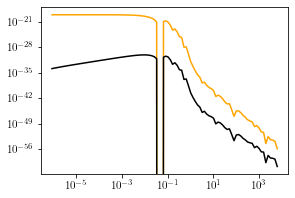

In [38]:
import DarkNews.phase_space as ps
Enu = 100
MA = maj_mc.ups_case.MA

Q2range=np.geomspace(ps.upscattering_Q2min(Enu, BSMparams.m4, MA),
            ps.upscattering_Q2max(Enu, BSMparams.m4, MA),
            100)
dsdq2_maj = amplitudes.upscattering_amplitude([Enu*MA*2+MA**2,-Q2range,0.0], process=maj_mc.ups_case)
dsdq2_dir = amplitudes.upscattering_amplitude([Enu*MA*2+MA**2,-Q2range,0.0], process=dir_mc.ups_case)

plt.plot(Q2range, dsdq2_maj, c='orange')
plt.plot(Q2range, dsdq2_dir, c='black')
plt.yscale("log")
plt.xscale("log")